# Mammogram Mass

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.

A lot of unnecessary anguish and surgery arises from false positives arising from mammogram results. If we can build a better way to interpret them through supervised machine learning, it could improve a lot of lives.


## Prepare your data

Start by importing the mammographic_masses.data.txt file into a Pandas dataframe

In [2]:
import pandas as pd


# Define the column names
column_names = ['BI-RADS', 'Age', 'Shape', 'Margin', 'Density', 'Severity']




The optional parmaters in read_csv to convert missing data (indicated by a ?) into NaN, and to add the appropriate column names (BI_RADS, age, shape, margin, density, and severity):

In [3]:
# Load the dataset, replacing '?' with NaN
data = pd.read_csv("mammographic_masses.data.txt", header=None, names=column_names, na_values='?')


Evaluate whether the data needs cleaning; model is only as good as the data it's given.

In [4]:
data.describe()

,BI-RADS,Age,Shape,Margin,Density,Severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


There are quite a few missing values in the data set. Before we just drop every row that's missing data, let's make sure we don't bias our data in doing so. 

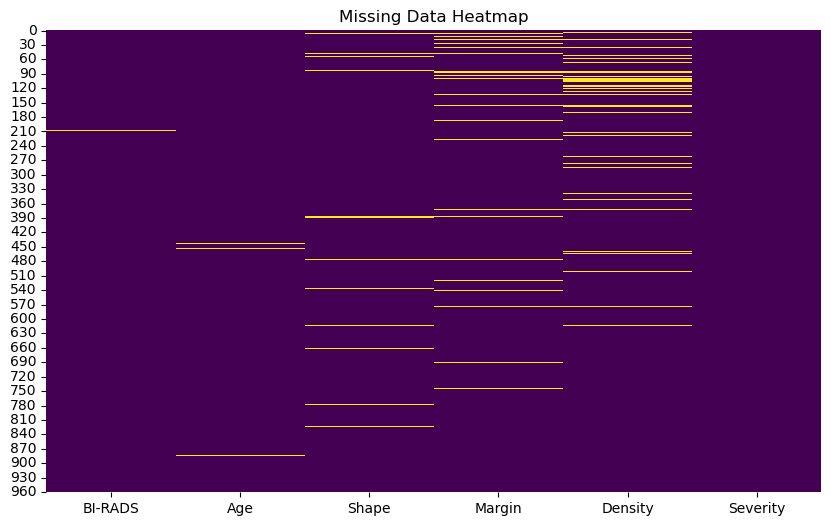

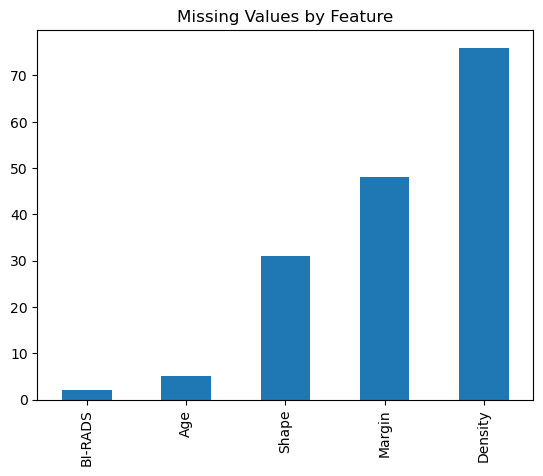

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize missing data with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

# Alternatively, a bar plot of missing data counts
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data.plot(kind='bar')
plt.title("Missing Values by Feature")
plt.show()


Correlation between missing values and other features:
BI-RADS    NaN
Age        NaN
Shape      NaN
Margin     NaN
Density    NaN
Severity   NaN
dtype: float64


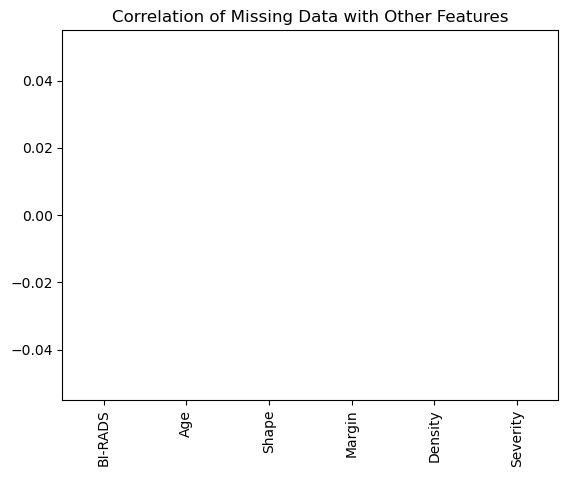

In [6]:
# Create a DataFrame indicating whether each value is missing (1 if missing, 0 otherwise)
missing_indicators = data.isnull().astype(int)

# Calculate correlations between missing indicators and other features
correlations = missing_indicators.corrwith(data.drop(columns='Severity'), method='pearson')
print("Correlation between missing values and other features:")
print(correlations)

# Visualize the correlations
correlations.plot(kind='bar')
plt.title("Correlation of Missing Data with Other Features")
plt.show()


If the missing data seems randomly distributed,  drop rows with missing data.

In [7]:
# Drop rows with any missing values
data_cleaned = data.dropna()

# Verify that there are no more missing values
print("Number of missing values after dropping rows:")
print(data_cleaned.isnull().sum())

# Display the shape of the cleaned dataset
print("\nShape of the dataset after dropping rows with missing data:")
print(data_cleaned.shape)


Number of missing values after dropping rows:
BI-RADS     0
Age         0
Shape       0
Margin      0
Density     0
Severity    0
dtype: int64

Shape of the dataset after dropping rows with missing data:
(830, 6)


Need to convert the Pandas dataframes into numpy arrays that can be used by scikit_learn. An array that extracts only the feature data we want to work with (age, shape, margin, and density) and another array that contains the classes (severity). 

In [8]:
import numpy as np

# Extract features (age, shape, margin, density) and convert to NumPy array
X = data_cleaned[['Age', 'Shape', 'Margin', 'Density']].values

# Extract classes (severity) and convert to NumPy array
y = data_cleaned['Severity'].values

# Extract feature names
feature_names = ['Age', 'Shape', 'Margin', 'Density']

# Display the shapes of the arrays
print(f"Feature array shape: {X.shape}")
print(f"Class array shape: {y.shape}")


Feature array shape: (830, 4)
Class array shape: (830,)


Some of models require the input data to be normalized, so go ahead and normalize the attribute data.

In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the features and transform the data
X_normalized = scaler.fit_transform(X)

# Display the first few rows of the normalized feature data
print("First few rows of the normalized feature data:")
print(X_normalized[:5])


First few rows of the normalized feature data:
[[ 0.7650629   0.17563638  1.39618483  0.24046607]
 [ 0.15127063  0.98104077  1.39618483  0.24046607]
 [-1.89470363 -1.43517241 -1.157718    0.24046607]
 [ 0.08307148 -1.43517241  1.39618483  0.24046607]
 [ 1.37885518 -1.43517241  0.75770912  0.24046607]]


## Decision Trees

Moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [10]:
from sklearn.model_selection import train_test_split

# Split the data: 75% for training, 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

# Display the shapes of the resulting arrays
print(f"Training feature array shape: {X_train.shape}")
print(f"Testing feature array shape: {X_test.shape}")
print(f"Training class array shape: {y_train.shape}")
print(f"Testing class array shape: {y_test.shape}")


Training feature array shape: (622, 4)
Testing feature array shape: (208, 4)
Training class array shape: (622,)
Testing class array shape: (208,)


Now create a DecisionTreeClassifier and fit it to your training data.

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Display the classifier's properties (optional)
print(clf)


DecisionTreeClassifier(random_state=42)


Display the resulting decision tree.

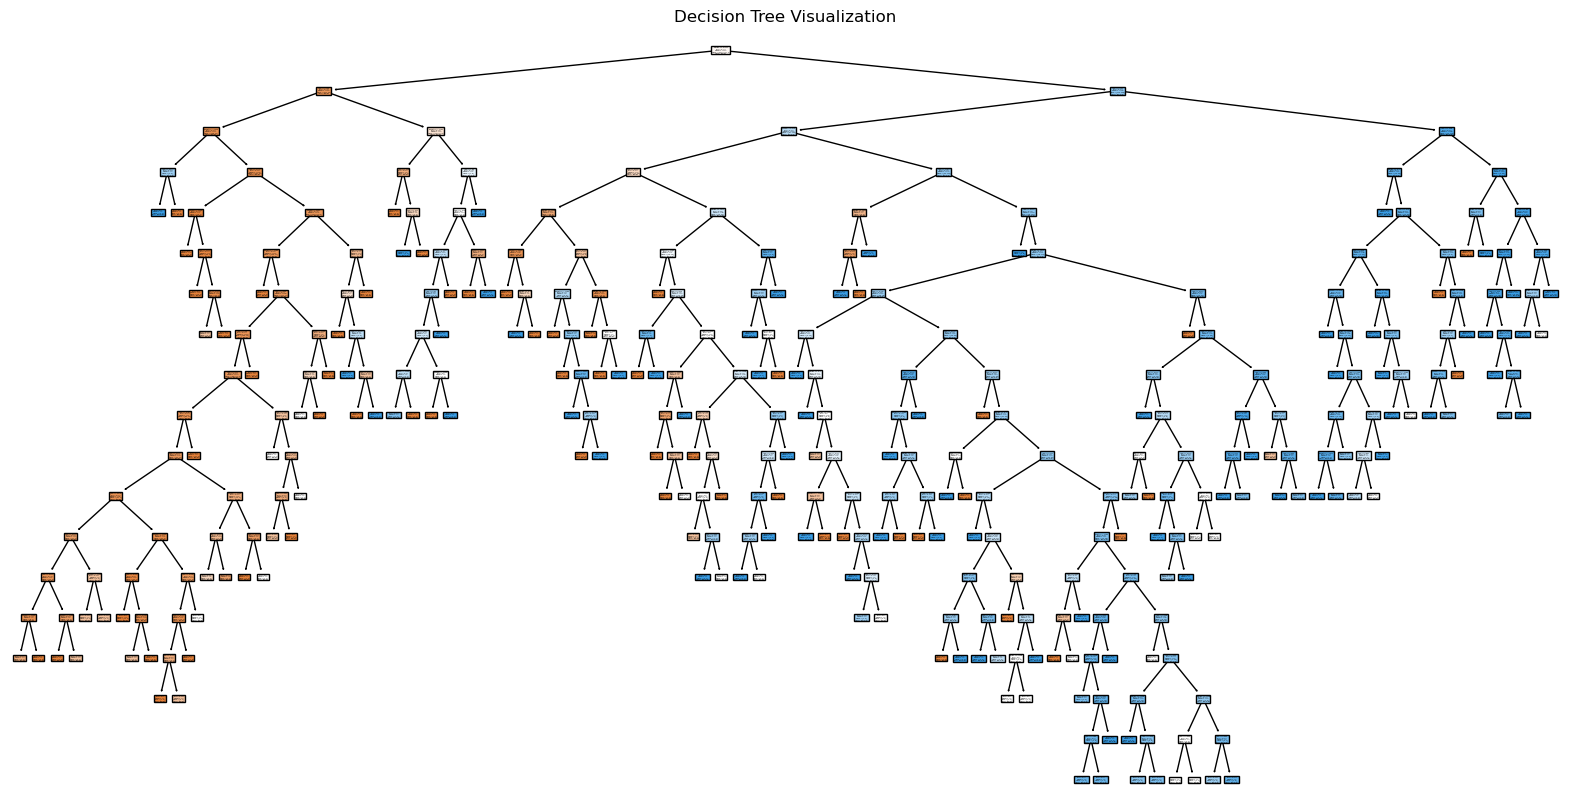

'\nfrom IPython.display import Image  \nfrom io import StringIO  \nfrom sklearn import tree\nfrom pydotplus import graph_from_dot_data \n\ndot_data = StringIO()  \ntree.export_graphviz(clf, out_file=dot_data,  \n                         feature_names=feature_names)  \ngraph = graph_from_dot_data(dot_data.getvalue())  \nImage(graph.create_png())  \n'

In [16]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=feature_names, class_names=['Benign', 'Malignant'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


'''
from IPython.display import Image  
from io import StringIO  
from sklearn import tree
from pydotplus import graph_from_dot_data 

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=feature_names)  
graph = graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  
'''

In [22]:
from sklearn.tree import export_text

# Get a textual representation of the tree
tree_rules = export_text(clf, feature_names=feature_names)
print("Decision Tree Rules:")
print(tree_rules)


Decision Tree Rules:
|--- Margin <= -0.84
|   |--- Age <= 0.80
|   |   |--- Density <= -4.04
|   |   |   |--- Age <= -0.80
|   |   |   |   |--- class: 1
|   |   |   |--- Age >  -0.80
|   |   |   |   |--- class: 0
|   |   |--- Density >  -4.04
|   |   |   |--- Age <= -1.04
|   |   |   |   |--- Shape <= -1.03
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Shape >  -1.03
|   |   |   |   |   |--- Age <= -1.55
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Age >  -1.55
|   |   |   |   |   |   |--- Age <= -1.45
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Age >  -1.45
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |--- Age >  -1.04
|   |   |   |   |--- Shape <= -0.23
|   |   |   |   |   |--- Density <= -1.19
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Density >  -1.19
|   |   |   |   |   |   |--- Age <= 0.66
|   |   |   |   |   |   |   |--- Age <= 0.39
|   |   |   |   |   |   |   |   |--- Age <= 0.12
|   |   |   |   

Measure the accuracy of the resulting decision tree model using test data.

In [23]:
from sklearn.metrics import accuracy_score
# Make predictions using the test data
y_pred = clf.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the Decision Tree model: {accuracy:.2f}")


Accuracy of the Decision Tree model: 0.77


Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=10).

In [24]:
from sklearn.model_selection import cross_val_score
# Perform 10-Fold Cross-Validation
cv_scores = cross_val_score(clf, X_normalized, y, cv=10, scoring='accuracy')

# Print the cross-validation scores
print(f"Cross-Validation Scores (K=10): {cv_scores}")

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean Accuracy: {cv_scores.mean():.2f}")
print(f"Standard Deviation: {cv_scores.std():.2f}")


Cross-Validation Scores (K=10): [0.73493976 0.75903614 0.73493976 0.75903614 0.78313253 0.69879518
 0.73493976 0.74698795 0.75903614 0.6746988 ]
Mean Accuracy: 0.74
Standard Deviation: 0.03


Now try a RandomForestClassifier instead.

In [25]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
# Perform 10-Fold Cross-Validation with RandomForestClassifier
rf_cv_scores = cross_val_score(rf_clf, X_normalized, y, cv=10, scoring='accuracy')

# Print the cross-validation scores
print(f"Cross-Validation Scores with RandomForestClassifier (K=10): {rf_cv_scores}")

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean Accuracy: {rf_cv_scores.mean():.2f}")
print(f"Standard Deviation: {rf_cv_scores.std():.2f}")


Cross-Validation Scores with RandomForestClassifier (K=10): [0.72289157 0.80722892 0.80722892 0.75903614 0.80722892 0.72289157
 0.77108434 0.78313253 0.77108434 0.68674699]
Mean Accuracy: 0.76
Standard Deviation: 0.04


## SVM

SVC with a linear kernel.

In [35]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the SVM model with a linear kernel
svm_model = svm.SVC(kernel='linear', random_state=42)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(svm_model, X_scaled, y, cv=10)

# Output the mean accuracy and standard deviation
print(f"SVM Model Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")


SVM Model Accuracy: 0.7976 (+/- 0.0511)


## KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the KNN model with K=10
knn_model = KNeighborsClassifier(n_neighbors=10)

# Perform 10-fold cross-validation
cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=10)

# Output the mean accuracy and standard deviation
print(f"KNN Model Accuracy: {np.mean(cv_scores_knn):.4f} (+/- {np.std(cv_scores_knn):.4f})")


KNN Model Accuracy: 0.7904 (+/- 0.0467)


Choosing K is tricky, so we can't discard KNN until we've tried different values of K. A for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. 

In [37]:
# Try different values of K
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=10)
    print(f"KNN Model with K={k}: Accuracy: {np.mean(cv_scores_knn):.4f} (+/- {np.std(cv_scores_knn):.4f})")


KNN Model with K=1: Accuracy: 0.7157 (+/- 0.0509)
KNN Model with K=2: Accuracy: 0.6904 (+/- 0.0575)
KNN Model with K=3: Accuracy: 0.7530 (+/- 0.0566)
KNN Model with K=4: Accuracy: 0.7386 (+/- 0.0414)
KNN Model with K=5: Accuracy: 0.7771 (+/- 0.0448)
KNN Model with K=6: Accuracy: 0.7723 (+/- 0.0398)
KNN Model with K=7: Accuracy: 0.7964 (+/- 0.0483)
KNN Model with K=8: Accuracy: 0.7819 (+/- 0.0446)
KNN Model with K=9: Accuracy: 0.7892 (+/- 0.0445)
KNN Model with K=10: Accuracy: 0.7904 (+/- 0.0467)
KNN Model with K=11: Accuracy: 0.7904 (+/- 0.0455)
KNN Model with K=12: Accuracy: 0.7831 (+/- 0.0403)
KNN Model with K=13: Accuracy: 0.7880 (+/- 0.0386)
KNN Model with K=14: Accuracy: 0.7855 (+/- 0.0352)
KNN Model with K=15: Accuracy: 0.7831 (+/- 0.0310)
KNN Model with K=16: Accuracy: 0.7831 (+/- 0.0361)
KNN Model with K=17: Accuracy: 0.7819 (+/- 0.0401)
KNN Model with K=18: Accuracy: 0.7831 (+/- 0.0464)
KNN Model with K=19: Accuracy: 0.7843 (+/- 0.0468)
KNN Model with K=20: Accuracy: 0.7855 (+

In [38]:
# Initialize variables to store the best K and corresponding accuracy
best_k = 1
best_accuracy = 0

# Loop over K values from 1 to 50
for k in range(1, 51):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=10)
    mean_accuracy = np.mean(cv_scores_knn)
    
    # Print the accuracy for the current K
    print(f"KNN Model with K={k}: Accuracy: {mean_accuracy:.4f} (+/- {np.std(cv_scores_knn):.4f})")
    
    # Update the best K and accuracy if the current one is better
    if mean_accuracy > best_accuracy:
        best_k = k
        best_accuracy = mean_accuracy

# Output the best K and corresponding accuracy
print(f"\nBest K: {best_k} with Accuracy: {best_accuracy:.4f}")


KNN Model with K=1: Accuracy: 0.7157 (+/- 0.0509)
KNN Model with K=2: Accuracy: 0.6904 (+/- 0.0575)
KNN Model with K=3: Accuracy: 0.7530 (+/- 0.0566)
KNN Model with K=4: Accuracy: 0.7386 (+/- 0.0414)
KNN Model with K=5: Accuracy: 0.7771 (+/- 0.0448)
KNN Model with K=6: Accuracy: 0.7723 (+/- 0.0398)
KNN Model with K=7: Accuracy: 0.7964 (+/- 0.0483)
KNN Model with K=8: Accuracy: 0.7819 (+/- 0.0446)
KNN Model with K=9: Accuracy: 0.7892 (+/- 0.0445)
KNN Model with K=10: Accuracy: 0.7904 (+/- 0.0467)
KNN Model with K=11: Accuracy: 0.7904 (+/- 0.0455)
KNN Model with K=12: Accuracy: 0.7831 (+/- 0.0403)
KNN Model with K=13: Accuracy: 0.7880 (+/- 0.0386)
KNN Model with K=14: Accuracy: 0.7855 (+/- 0.0352)
KNN Model with K=15: Accuracy: 0.7831 (+/- 0.0310)
KNN Model with K=16: Accuracy: 0.7831 (+/- 0.0361)
KNN Model with K=17: Accuracy: 0.7819 (+/- 0.0401)
KNN Model with K=18: Accuracy: 0.7831 (+/- 0.0464)
KNN Model with K=19: Accuracy: 0.7843 (+/- 0.0468)
KNN Model with K=20: Accuracy: 0.7855 (+

## Naive Bayes

Now try naive_bayes.MultinomialNB.

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import preprocessing

from sklearn.naive_bayes import MultinomialNB

scaler = preprocessing.MinMaxScaler()
all_features_minmax = scaler.fit_transform(X)

# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Perform 10-fold cross-validation
cv_scores_nb = cross_val_score(nb_model, all_features_minmax, y, cv=10)

# Output the mean accuracy and standard deviation
print(f"Naive Bayes Model Accuracy: {np.mean(cv_scores_nb):.4f} (+/- {np.std(cv_scores_nb):.4f})")


Naive Bayes Model Accuracy: 0.7855 (+/- 0.0527)


## Revisiting SVM

svm.SVC may perform differently with different kernels. The choice of kernel is an example of a "hyperparamter." Trying out the rbf, sigmoid, and poly kernels and see what the best-performing kernel is.

In [49]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the kernels to evaluate
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
best_kernel = None
best_accuracy = 0

# Loop through each kernel
for kernel in kernels:
    svm_model = svm.SVC(kernel=kernel)
    cv_scores_svm = cross_val_score(svm_model, X_scaled, y, cv=10)
    mean_accuracy = np.mean(cv_scores_svm)
    
    # Print the accuracy for the current kernel
    print(f"SVM Model with {kernel} kernel: Accuracy: {mean_accuracy:.4f} (+/- {np.std(cv_scores_svm):.4f})")
    
    # Update the best kernel if current kernel performs better
    if mean_accuracy > best_accuracy:
        best_kernel = kernel
        best_accuracy = mean_accuracy

# Output the best-performing kernel and corresponding accuracy
print(f"\nBest Kernel: {best_kernel} with Accuracy: {best_accuracy:.4f}")


SVM Model with linear kernel: Accuracy: 0.7976 (+/- 0.0511)
SVM Model with rbf kernel: Accuracy: 0.8012 (+/- 0.0401)
SVM Model with sigmoid kernel: Accuracy: 0.7458 (+/- 0.0398)
SVM Model with poly kernel: Accuracy: 0.7904 (+/- 0.0393)

Best Kernel: rbf with Accuracy: 0.8012


## Neural Networks

An artificial neural network can do even better. Used Keras to set up a neural network with 1 binary output neuron and see how it performs.

In [11]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    #feature inputs going into an 6-unit layer
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; adam 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
y

array([1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,

In [15]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Wrap our Keras model in an estimator compatible with scikit_learn
estimator = KerasClassifier(model=create_model, epochs=100, verbose=0)
# Now we can use scikit_learn's cross_val_score to evaluate this model identically to the others
cv_scores = cross_val_score(estimator, X_scaled, y, cv=10)
cv_scores.mean()


/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/manavchetwani/Downloads/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

0.8036144578313253